In [1]:
from torch.utils.data import DataLoader

import numpy as np
import time
import sys
import os
import torch

from models import utils, caption
import spacy
try:
    spacy_eng = spacy.load("en")
except:
    spacy_eng = spacy.load("en_core_web_sm")
def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]
from datasets import coco
from configuration import Config
from engine import train_one_epoch, evaluate

In [2]:
config = Config()

## Dataset Creation
Note: Run the below code twice, once for val captions and once for train captions

In [3]:
os.getcwd()
os.path.abspath("..\\..\\datasets")

'd:\\Shailesh\\datasets'

In [4]:
os.path.exists("..\\..\\datasets\\coco2017")

True

In [14]:
from datasets.utils import read_json
import re
file_name = os.path.join(config.dir, 'annotations', 'captions_val2017.json')
ann = read_json(file_name)

In [15]:
def _process(image_id):
    val = str(image_id).zfill(12)
    return val + '.jpg'

In [16]:
annot = [(_process(val['image_id']), 
                re.sub(' +', ' ', (
                    re.sub("\((.*?)\)", " ",(val['caption']
                                                 .replace(".", " ")
                                                 .replace(",", " ")
                                                 .replace(":", " ")
                                                 .replace("-", " ")
                                                 .replace('"', ' ')
                                                 .replace('/', ' or ')
                                                 .replace("!", " ")
                                                 .replace('`', " ")
                                                 .replace("#", " ")
                                                 .replace(' & ', ' and ')
                                                 .replace("*s", "'s")
                                                 .replace("[", " ")
                                                 .replace("/", " ")
                                                 .replace("?", " ")
                                                 .replace(">", " ")
                                                 .lower())))
)) 
for val in ann['annotations']]

Punctuaton marks allowed in captions:   
- 's   
    
After this, search for $ and remove the 2 captions from training set.   
search for + and remove 2+   
replace ] with l

In [17]:
annot[0]

('000000179765.jpg', 'a black honda motorcycle parked in front of a garage ')

In [18]:
# Keywords in captions  for any scene at home
room_words = ['bedroom', 'room', 'table', 'chair', 'recliner', 'pillow', 'cupboard', 'wardrobe', 'dining', 'sofa', 'kitchen', 'clock', 'tv', 'television', 'curtain', 'telephone', 'kitchen', 'fan', 'lamp', 'carpet', 'beanbag', 'fireplace', 'book', 'bookshelf', 'speaker', 'drape', 'plant', 'pot', 'desk', 'mirror', 'bulb', 'fridge', 'refrigerator', 'bathroom']


In [19]:
annot_txt = open("val_captions.txt", "w")
for id, caption in annot:
    # if any room_word is present in caption, write it in the file
    for word in room_words:
        if word in caption:
            line = id+ "\t"+  caption
            annot_txt.write(line + "\n")
            break
annot_txt.close()

Remove empty lines and correct caption alignment

In [20]:
# Read the file containing all caption-image pairs
with open('val_captions.txt', 'r') as file:
    annotations = file.read()

file2 = open("val_captions_2.txt", "w")
# splitting the file contents by line
for i, annot in enumerate(annotations.split("\n")):
        # Skip empty lines
        if len(annot)<1:
            print(i, "length less than 1")
            continue
        file2.write(annot+"\n")

file2.close()

9 length less than 1
163 length less than 1
283 length less than 1
329 length less than 1
866 length less than 1
1041 length less than 1
1916 length less than 1
2500 length less than 1
2536 length less than 1
2916 length less than 1
2917 length less than 1
3051 length less than 1
3299 length less than 1
3378 length less than 1
4227 length less than 1
4228 length less than 1
4349 length less than 1
5189 length less than 1


In [21]:
# Read the file containing all caption-image pairs
with open('val_captions_2.txt', 'r') as file:
    annotations = file.read()

# Store captions and image names in vectors
all_words = []

# splitting the file contents by line
for i, annot in enumerate(annotations.split("\n")):
        # Skip empty lines
        if len(annot)<1:
            print(i, "length less than 1")
            continue
        caption = annot.split()[1:]
        if len(caption)<2:
            print(i, "no caption")

5172 length less than 1


In [51]:
# Read the file containing all caption-image pairs
with open('train_captions.txt', 'r') as file:
    annotations = file.read()

# Store captions and image names in lists
all_captions = []
all_imgs = []

# splitting the file contents by line
for annot in annotations.split("\n"):
        # Skip empty lines
        if len(annot)<1:
            continue
        caption = annot.split()[1:]
        try:
            image_id = annot.split()[0]
        except:
            print(image_id, ":", caption)

        all_imgs.append(image_id)
        all_captions.append(caption)

In [56]:
train_ids = sorted(set(all_imgs))
len(train_ids)

40054

In [57]:
# Read the file containing all caption-image pairs
with open('val_captions.txt', 'r') as file:
    annotations = file.read()

# Store captions and image names in vectors
all_captions = []
all_imgs = []

# splitting the file contents by line
for annot in annotations.split("\n"):
        # Skip empty lines
        if len(annot)<1:
            continue
        caption = annot.split()[1:]
        try:
            image_id = annot.split()[0]
        except:
            print(image_id, ":", caption)

        all_imgs.append(image_id)
        all_captions.append(caption)

val_ids = sorted(set(all_imgs))
len(val_ids)

1711

Observation:
- **121508 image caption pairs** for training set with 40054 unique images.
- **5090 image caption** pairs for validation set with 1711 unique images.

## Create Tokenizer

In [4]:
import spacy
from torchtext.data import Field
import torch
import numpy as np
from configuration import Config

In [21]:
caption = "The room has a sofa"

In [22]:
# Read the file containing all caption-image pairs
with open('train_captions.txt', 'r') as file:
    annotations = file.read()

# Store captions and image names in vectors
all_words = []

# splitting the file contents by line
for annot in annotations.split("\n"):
        # Skip empty lines
        if len(annot)<1:
            continue
        caption = annot.split()[1:]
        caption = " ".join(caption)
        caption = english.tokenize(caption)
        all_words += caption 

all_words = list(set(all_words))
len(all_words)

13838

In [5]:
spacy_eng = spacy.load("en")
def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]
english = Field(tokenize=tokenize_eng, lower=True, init_token="<sos>", eos_token="<eos>")

In [24]:
english.build_vocab([all_words])
len(english.vocab.stoi.keys())

13842

In [10]:
torch.save(english, "english.pth")

In [9]:
import torch
english = torch.load('english.pth')

In [15]:
tokens = english.tokenize("Hello this is shailesh's phone")
tokens = ['<sos>'] + tokens + ['<eos>']
numbs = english.numericalize([tokens])

In [26]:
tokens, numbs.T

(['<sos>', 'Hello', 'this', 'is', 'shailesh', "'s", 'phone', '<eos>'],
 tensor([[    2,  1151, 12635,  7719,     0,    13,  9728,     3]]))

In [17]:
toks = numbs.numpy().T[0]
toks

array([    2,  1151, 12635,  7719,     0,    13,  9728,     3])

In [18]:
config=Config()
caption = np.zeros(config.max_position_embeddings)
caption[:len(toks)] = toks
caption

array([2.0000e+00, 1.1510e+03, 1.2635e+04, 7.7190e+03, 0.0000e+00,
       1.3000e+01, 9.7280e+03, 3.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [28]:
english.vocab.itos[2]

'<sos>'

In [20]:
cap_mask = np.ones(config.max_position_embeddings)
cap_mask[:len(toks)] = 0
cap_mask

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
##################################

In [4]:
# Code to successfully run coco.build_dataset
import spacy
from configuration import Config
from datasets import coco

config = Config()
spacy_eng = spacy.load("en")
def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]
data = coco.build_dataset(config, mode="training")

In [11]:
image, mask, caption, cap_mask = data[10]

In [25]:
cap_mask

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
############################################

## Transfer Learning Using DETR

In [1]:
from torch.utils.data import DataLoader

import numpy as np
import time
import sys
import os
import torch

from models import utils, caption
import spacy
spacy_eng = spacy.load("en")
def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]
from datasets import coco
from configuration import Config
from engine import train_one_epoch, evaluate

In [1]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)

Using cache found in /home/shailesh/.cache/torch/hub/facebookresearch_detr_master


In [2]:
torch.save(model.backbone.state_dict(), "pretrained_wts/backbone.pth")

In [7]:
torch.save(model.transformer.encoder.state_dict(), "pretrained_wts/trans-encoder.pth")

In [2]:
my_model, _ = caption.build_model(config=Config())

In [3]:
my_model.backbone.load_state_dict(torch.load("pretrained_wts/backbone.pth"), strict = False)

<All keys matched successfully>

In [4]:
my_model.transformer.encoder.load_state_dict(torch.load("pretrained_wts/trans-encoder.pth"), strict = False)

<All keys matched successfully>

In [6]:
torch.save(my_model.state_dict(), "pretrained_wts/my_model.pth")

In [3]:
my_model.load_state_dict(torch.load("pretrained_wts/my_model.pth"))

<All keys matched successfully>

## Length of longest caption in dataset

In [1]:
with open("train_captions.txt") as file:
    text = file.read()

In [7]:
longest=0
for line in text.split('\n'):
    caption = line.split()[1:]
    caption = " ".join(caption)
    caption = english.tokenize(caption)
    caption = ['<sos>'] + caption + ['<eos>']
    longest = max(len(caption), longest)

In [8]:
longest

52

In [11]:
english.tokenize("A tall white birthday cake with a 6 candle on it sits with lit candles on a table; a dog bone has also been decorated and had a single candle lit and a lady is holding a white dog in the background ")

['A',
 'tall',
 'white',
 'birthday',
 'cake',
 'with',
 'a',
 '6',
 'candle',
 'on',
 'it',
 'sits',
 'with',
 'lit',
 'candles',
 'on',
 'a',
 'table',
 ';',
 'a',
 'dog',
 'bone',
 'has',
 'also',
 'been',
 'decorated',
 'and',
 'had',
 'a',
 'single',
 'candle',
 'lit',
 'and',
 'a',
 'lady',
 'is',
 'holding',
 'a',
 'white',
 'dog',
 'in',
 'the',
 'background']

In [47]:
"Hi (shjbnslb) this is me".replace("(*+)", "")

'Hi (shjbnslb) this is me'

In [ ]:
###########################

Check to see if training is possible in Colab with images in Drive

In [19]:
# Read the file containing all caption-image pairs
with open('train_captions_2.txt', 'r') as file:
    annotations = file.read()

image_ids = list()

# splitting the file contents by line
for i, annot in enumerate(annotations.split("\n")):
        image_id = annot.split()[0]
        # if image_id=='full':
        #     print(i, annot)
        #     break
        image_ids.append(image_id)

image_ids = set(image_ids)
len(image_ids)

73061 full of very tidily arranged piles of jeans and tops 


23527

In [2]:
print("Total space utilsed by images(GB):", 150*40262/1024/1024)

Total space utilsed by images(GB): 5.759525299072266


Conclusion: With Drive storage limit at 15GB, it is possible to upload the entire dataset to Drive.

## Copy only relevant images for the dataset out of MSCOCO dataset

In [3]:
import shutil
import tqdm

In [10]:
training_folder = "train2017"
target_folder = os.path.abspath(os.path.join(".", "coco", training_folder))
source_folder = os.path.abspath(os.path.join("..","..", "datasets", "coco2017", training_folder))
os.path.exists(source_folder)

True

In [5]:
image_ids = list(image_ids)

start=0

with tqdm.tqdm(total=len(image_ids)) as pbar:
    for i in range(start, len(image_ids)):
        image_id = image_ids[i]
        try:
            shutil.copyfile(os.path.join(source_folder,image_id), os.path.join(target_folder,image_id))
        except:
            print(i, image_id)
        pbar.update(1)

100%|██████████| 40260/40260 [38:26<00:00, 17.46it/s]


In [18]:
################## Validation dataset code
# Read the file containing all caption-image pairs
with open('val_captions_2.txt', 'r') as file:
    annotations = file.read()

image_ids = list()

# splitting the file contents by line
for i, annot in enumerate(annotations.split("\n")):
        image_id = annot.split()[0]
        # if image_id=='with':
        #     print(i, annot)
        #     break
        image_ids.append(image_id)

image_ids = set(image_ids)
len(image_ids)

1716

In [7]:
training_folder = "val2017"
target_folder = os.path.abspath(os.path.join(".", "coco", training_folder))
source_folder = os.path.abspath(os.path.join("..","..", "datasets", "coco2017", training_folder))
os.path.exists(source_folder)

True

In [8]:
image_ids = list(image_ids)

start=0

with tqdm.tqdm(total=len(image_ids)) as pbar:
    for i in range(start, len(image_ids)):
        image_id = image_ids[i]
        try:
            shutil.copyfile(os.path.join(source_folder,image_id), os.path.join(target_folder,image_id))
        except:
            print(i, image_id)
        pbar.update(1)

100%|██████████| 1716/1716 [01:32<00:00, 18.52it/s]


#TODO
- Create word cloud

In [14]:
list(image_ids).index("full")

9033

## Wordcloud

In [1]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

In [2]:
# Read the file containing all caption-image pairs
with open('train_captions_2.txt', 'r') as file:
    annotations = file.read()

# Store captions and image names in vectors
train_captions = []

# splitting the file contents by line
for annot in annotations.split("\n"):
        caption = annot.split()[1:]
        caption = " ".join(caption)
        train_captions.append(caption)


In [3]:
train_captions[0]

'a bicycle replica with a clock as the front wheel'

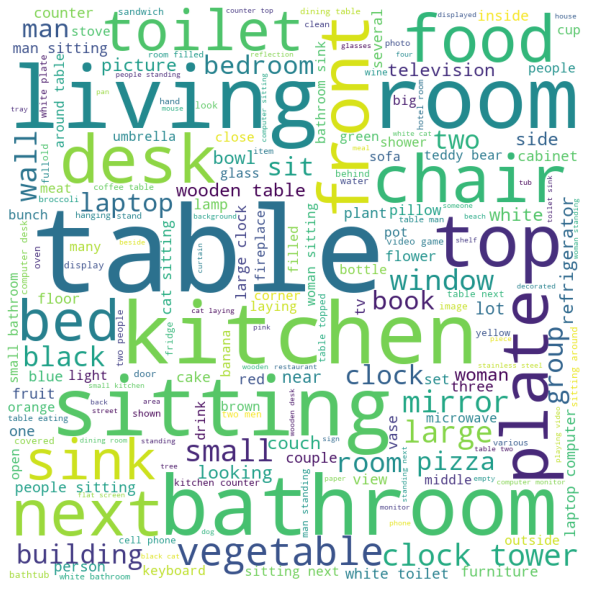

In [12]:
# captions = train_captions

# comment_words = '' 
# stopwords = set(STOPWORDS) 

# # iterate through the csv file 
# for val in captions: 
	
# 	# typecaste each val to string 
# 	val = str(val) 

# 	# split the value 
# 	tokens = val.split() 
	
# 	# Converts each token into lowercase 
# 	for i in range(len(tokens)): 
# 		tokens[i] = tokens[i].lower() 
	
# 	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='white', 
				stopwords = stopwords, 
				min_font_size = 10).generate(comment_words) 

wordcloud.to_image().save("images/wordclod-200-white.png")

# plot the WordCloud image					 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


In [11]:
type(wordcloud.to_image())

PIL.Image.Image

In [13]:
wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='white', 
				stopwords = stopwords, 
				min_font_size = 10, max_words=350).generate(comment_words) 

wordcloud.to_image().save("images/wordclod-350-white.png")

In [14]:
wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='white', 
				stopwords = stopwords, 
				min_font_size = 10, max_words=500).generate(comment_words) 

wordcloud.to_image().save("images/wordclod-500-white.png")

In [16]:
wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='black', 
				stopwords = stopwords, 
				min_font_size = 10).generate(comment_words) 

wordcloud.to_image().save("images/wordclod-200-black.png")

## Divide the checkpoint file to multiple files   
This step is necessary to store the model weights in GitHub. This is because checkpoint file has a size of 600 MB and GitHub allows max file size of 100 MB   
<br>   
Assumptions: checkpoints/checkpoint.pth is the best model. 

In [1]:
import torch
from models import caption
from configuration import Config

In [2]:
config = Config()
model, _ = caption.build_model(config)

checkpoint = torch.load(config.checkpoint, map_location='cpu')

model.load_state_dict(checkpoint['model'])
print("Loaded Checkpoint:", config.checkpoint)

In [11]:
torch.save(model.backbone.state_dict(), "checkpoints/checkpoint-breakdown/backbone.pth")
torch.save(model.input_proj.state_dict(), "checkpoints/checkpoint-breakdown/input_proj.pth")
torch.save(model.transformer.state_dict(), "checkpoints/checkpoint-breakdown/transformer.pth")
torch.save(model.mlp.state_dict(), "checkpoints/checkpoint-breakdown/mlp.pth")

In [5]:
# To load model weights, use the code below
model.backbone.load_state_dict(torch.load("checkpoints/checkpoint-breakdown/backbone.pth", map_location='cpu'))
model.input_proj.load_state_dict(torch.load("checkpoints/checkpoint-breakdown/input_proj.pth", map_location='cpu'))
model.transformer.load_state_dict(torch.load("checkpoints/checkpoint-breakdown/transformer.pth", map_location='cpu'))
model.mlp.load_state_dict(torch.load("checkpoints/checkpoint-breakdown/mlp.pth", map_location='cpu'))
model.to("cuda" if torch.cuda.is_available() else "cpu")

## Model Selection   
I have used bleu score to compare and get the best model

In [12]:
import pandas as pd
history_file = "./history/history.csv"
history = pd.read_csv(filepath_or_buffer=history_file)
history

,epoch,bleu_1,bleu_2,bleu_3,bleu_4
0,1.0,0.744011,0.648337,0.565692,0.115061
1,2.0,0.776046,0.684011,0.604327,0.137107
2,3.0,0.796247,0.702507,0.621715,0.141966
3,4.0,0.802209,0.708114,0.626163,0.140117
4,5.0,0.798642,0.706598,0.626102,0.147445
5,6.0,0.805218,0.718345,0.640668,0.160358
6,7.0,0.798328,0.711003,0.634181,0.159765
7,8.0,0.813590,0.723960,0.644306,0.157909
8,9.0,0.814674,0.724952,0.647072,0.160608
9,10.0,0.808429,0.722143,0.645776,0.166069


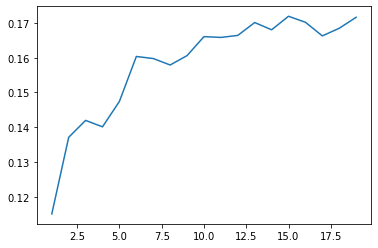

In [13]:
import matplotlib.pyplot as plt


# plt.plot(history.epoch, history.bleu_1)
# plt.plot(history.epoch, history.bleu_2)
# plt.plot(history.epoch, history.bleu_3)
plt.plot(history.epoch, history.bleu_4)
# plt.plot(history.epoch, history.training_loss)
plt.show()